In [1]:
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry
from scripts import create_datasets, calculate_segmentation_metrics
import numpy as np
from sklearn.metrics import precision_recall_curve
import cv2



In [2]:
batch_size = 1
train_dataset, val_dataset, test_dataset = create_datasets(dataset_info_path='dataset/TNBC/dataset_info.json')
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [3]:
model_type = 'vit_b'
pretrained_weight_path = 'weights/MySam/BinaryMaskLoss/lr0.001_bs2_pwTrue_fimage_encoder+prompt_encoder_add/2024-04-11-13.42_16.pth'
sam = sam_model_registry[model_type](pretrained_weight_path)
sam.eval()


MySam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    

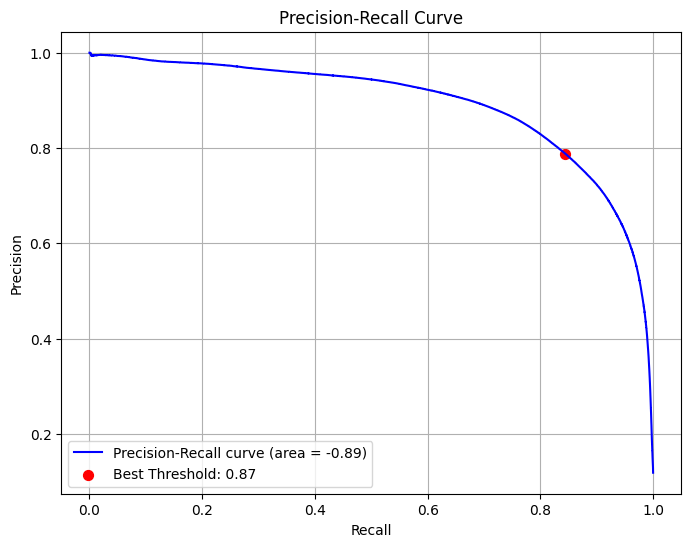

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


def plot_pr_curve_for_dataset(y_true_list, y_pred_prob_list):
    all_y_true = np.concatenate(y_true_list)
    all_y_pred_prob = np.concatenate(y_pred_prob_list)

    precision, recall, thresholds = precision_recall_curve(all_y_true.flatten(), all_y_pred_prob.flatten())
    area_under_curve = np.trapz(precision, recall)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', label='Precision-Recall curve (area = {:.2f})'.format(area_under_curve))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid(True)

    # 寻找最佳阈值点
    best_threshold_index = np.argmax(precision + recall)
    best_threshold = thresholds[best_threshold_index]
    plt.scatter(recall[best_threshold_index], precision[best_threshold_index], c='red', s=50, label='Best Threshold: {:.2f}'.format(best_threshold))
    plt.legend(loc='best')

    plt.show()
    return best_threshold

# 用法示例
# 假设 y_true_list 是整个验证集的真实标签列表，y_pred_prob_list 是整个验证集的模型输出的概率结果列表（每个像素点的概率）
y_true_list = label_list

y_pred_prob_list = pred_arr_list

threshold = plot_pr_curve_for_dataset(y_true_list, y_pred_prob_list)

In [4]:
threshold = 0.87

In [5]:
def visualize_predictions(label_image, prediction_image):
    # 确保两个图像具有相同的尺寸
    if label_image.shape != prediction_image.shape:
        raise ValueError("Label and prediction images must have the same dimensions.")

    # 创建新图像，尺寸与输入图像相同
    fn = (prediction_image.astype(int) - label_image.astype(int)) < 0
    fp = (label_image.astype(int) - prediction_image.astype(int)) < 0
    tp = prediction_image.astype(int) - fp.astype(int)

    return np.array([fp.astype(int), tp.astype(int), fn.astype(int)]).transpose(1, 2, 0).astype(np.uint8) * 255



def draw_contours_on_image(binary_mask, original_image):
    # 寻找连通域
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 创建一个空白图像，与原始图像大小和通道数相同
    result_image = original_image.copy()

    # 在结果图像上绘制每个连通域的轮廓
    cv2.drawContours(result_image, contours, -1, (0, 255, 0), 2)

    return result_image



In [6]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [7]:
import numpy as np

def split_batch_images_labels(batch):
    images_list = []
    labels_list = []
    for i in range(len(batch[0])):
        image = batch[0][i].detach().numpy().transpose(1, 2, 0)  # 将通道维度放在最后
        label = batch[1][i].detach().numpy().squeeze(0)  # 去掉第一个维度，因为标签的维度是[bs, 1, h, w]

        images_list.append(image)
        labels_list.append(label)
    return images_list, labels_list

images_list = []
labels_list = []
preds_list = []


for idx, batch in enumerate(test_loader):
    res = sam(batch[0], False)
    for i in range(len(res)):
        arr = torch.sigmoid(res)[i].squeeze(0).detach().numpy()
        arr = (arr > 0.87).astype(np.uint8)
        preds_list.append(arr)
    temp_imgs, temp_labels = split_batch_images_labels(batch)
    images_list.extend(temp_imgs)
    labels_list.extend(temp_labels)
    # break



[input_images shape in MySam: torch.Size([1, 3, 1024, 1024])]
[input_images shape in MySam: torch.Size([1, 3, 1024, 1024])]
[input_images shape in MySam: torch.Size([1, 3, 1024, 1024])]
[input_images shape in MySam: torch.Size([1, 3, 1024, 1024])]
[input_images shape in MySam: torch.Size([1, 3, 1024, 1024])]


In [13]:
import numpy as np

class MetricsCalculator:
    def __init__(self):
        self.metrics = {}

    def add_metric(self, name, fn):
        self.metrics[name] = fn

    @staticmethod
    def calculate_iou(gt_mask, pred_mask):
        intersection = np.logical_and(gt_mask, pred_mask)
        union = np.logical_or(gt_mask, pred_mask)
        iou = np.sum(intersection) / np.sum(union)
        return iou

    @staticmethod
    def calculate_miou(gt_masks, pred_masks):
        num_classes = len(gt_masks)
        miou = 0.0
        for i in range(num_classes):
            miou += MetricsCalculator.calculate_iou(gt_masks[i], pred_masks[i])
        miou /= num_classes
        return miou

    @staticmethod
    def calculate_precision(gt_mask, pred_mask):
        true_positive = np.sum(np.logical_and(gt_mask, pred_mask))
        false_positive = np.sum(np.logical_and(np.logical_not(gt_mask), pred_mask))
        precision = true_positive / (true_positive + false_positive + 1e-7)
        return precision

    @staticmethod
    def calculate_recall(gt_mask, pred_mask):
        true_positive = np.sum(np.logical_and(gt_mask, pred_mask))
        false_negative = np.sum(np.logical_and(gt_mask, np.logical_not(pred_mask)))
        recall = true_positive / (true_positive + false_negative + 1e-7)
        return recall

    @staticmethod
    def calculate_accuracy(gt_mask, pred_mask):
        true_positive = np.sum(np.logical_and(gt_mask, pred_mask))
        true_negative = np.sum(np.logical_and(np.logical_not(gt_mask), np.logical_not(pred_mask)))
        total_pixels = gt_mask.size
        accuracy = (true_positive + true_negative) / total_pixels
        return accuracy

    @staticmethod
    def calculate_f1(gt_mask, pred_mask):
        precision = MetricsCalculator.calculate_precision(gt_mask, pred_mask)
        recall = MetricsCalculator.calculate_recall(gt_mask, pred_mask)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
        return f1

    @staticmethod
    def calculate_specificity(gt_mask, pred_mask):
        true_negative = np.sum(np.logical_and(np.logical_not(gt_mask), np.logical_not(pred_mask)))
        false_positive = np.sum(np.logical_and(np.logical_not(gt_mask), pred_mask))
        specificity = true_negative / (true_negative + false_positive + 1e-7)
        return specificity

    @staticmethod
    def calculate_jaccard_index(gt_mask, pred_mask):
        intersection = np.logical_and(gt_mask, pred_mask)
        union = np.logical_or(gt_mask, pred_mask)
        jaccard_index = np.sum(intersection) / np.sum(union)
        return jaccard_index

    @staticmethod
    def calculate_dice_coefficient(gt_mask, pred_mask):
        intersection = np.logical_and(gt_mask, pred_mask)
        dice_coefficient = (2 * np.sum(intersection)) / (np.sum(gt_mask) + np.sum(pred_mask) + 1e-7)
        return dice_coefficient

    @staticmethod
    def calculate_sensitivity(gt_mask, pred_mask):
        true_positive = np.sum(np.logical_and(gt_mask, pred_mask))
        false_negative = np.sum(np.logical_and(gt_mask, np.logical_not(pred_mask)))
        sensitivity = true_positive / (true_positive + false_negative + 1e-7)
        return sensitivity

    def calculate_metrics(self, gt_masks, pred_masks):
        num_classes = len(gt_masks)

        metrics = {name: [] for name in self.metrics}

        for i in range(num_classes):
            for name, fn in self.metrics.items():
                value = fn(gt_masks[i], pred_masks[i])
                metrics[name].append(value)

        metrics_dict = {
            name: np.mean(values) for name, values in metrics.items()
        }

        return metrics_dict

{'Mean IoU': 0.6142857142857143, 'Mean Precision': 0.7999999815000004, 'Mean Recall': 0.6999999860000002, 'Mean Accuracy': 0.7222222222222222}


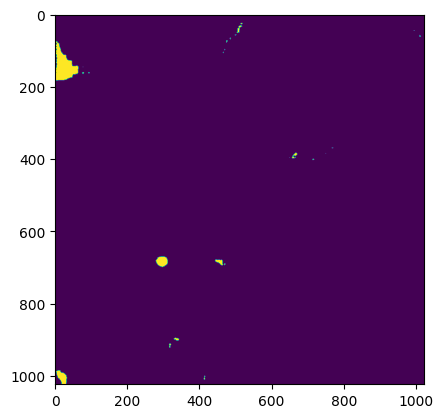

In [8]:
plt.imshow(preds_list[0])

In [10]:
from scripts import MetricsCalculator

metrics_calculator = MetricsCalculator()

# 在calculate_metrics中计算所有指标
metrics = metrics_calculator.calculate_metrics(labels_list, preds_list)

In [11]:
metrics

{'AccuracyMetric': 0.9482761383055738,
 'F1ScoreMetric': 0.6660512584809666,
 'IOUMetric': 0.5474135875474395,
 'MeanIoUMetric': nan,
 'PrecisionMetric': 0.7426370677414127,
 'RecallMetric': 0.6296789029344569}

In [61]:
for i in range(len(images_list)):
    arr = preds_list[i]
    original_label = labels_list[i].astype(np.uint8)
    ori_image = images_list[i]

    binary = arr > threshold
    binary = binary.astype(np.uint8)
    diff_mask = visualize_predictions(original_label, binary)
    ori_image = draw_contours_on_image(binary, ori_image)

    
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    # 设置第一个子图为预测结果
    axes[0].imshow(binary, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Prediction')

    # 设置第二个子图为原始标签
    axes[1].imshow(original_label, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Original Label')

    # 设置第三个子图为叠加结果
    axes[2].imshow(diff_mask)
    axes[2].axis('off')
    axes[2].set_title('G:TP R:FP B:FN')

    # 设置第三个子图为原始图像
    axes[3].imshow(ori_image)  # 假设原始图像是3通道的
    axes[3].axis('off')
    axes[3].set_title('Original Image')
    # 调整子图之间的间距
    plt.tight_layout()
    # 保存整个图形
    plt.savefig('predict_results/result_figure_{}.png'.format(i))
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
